<a href="https://colab.research.google.com/github/hermanhesse7/data-science-projects/blob/main/Renting_Price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2 align=right style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
مقدمه و صورت مسئله
</font>
</h2>

<p dir=rtl style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=3>
در سوال مجموعه‌داده‌ای از اقامتگاه‌های سایت جاجیگا در اخیار شما قرار داده شده است. هدف پیش‌بینی قیمت یک اقامتگاه با توجه به ویژگی‌ها و اطلاعات آن است.
    
</font>
</p>

In [542]:
%pip install catboost

In [543]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder

# train the linear model
from sklearn.ensemble import StackingRegressor
from sklearn.metrics import r2_score, make_scorer
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score, KFold

In [544]:
train_data = pd.read_csv("/content/drive/MyDrive/train.csv")
test_data = pd.read_csv("/content/drive/MyDrive/test.csv")

<h2 align=right style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
پیش‌پردازش و مهندسی ویژگی
</font>
</h2>

<p dir=rtl style="direction: rtl; text-align: justify; line-height:200%; font-family:vazir; font-size:medium">
<font face="vazir" size=3>
    در این سوال شما می‌توانید از هر تکنیک پیش‌پردازش یا مهندسی ویژگی، استفاده کنید.
    <br>
    تکنیک‌هایی که استفاده می‌کنید به شکل مستقیم مورد ارزیابی توسط سامانه داوری قرار <b>نمی‌گیرند.</b> بلکه همه آن‌ها در دقت مدل شما تاثیر خواهند گذاشت.
</font>
</p>

In [545]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4776 entries, 0 to 4775
Data columns (total 47 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           4776 non-null   int64  
 1   id                   4776 non-null   int64  
 2   status               4776 non-null   object 
 3   title                4776 non-null   object 
 4   description          4776 non-null   object 
 5   allocation           4776 non-null   object 
 6   types                4776 non-null   object 
 7   regions              4776 non-null   object 
 8   floor_area           4776 non-null   int64  
 9   land_area            4776 non-null   int64  
 10  floors_count         4776 non-null   int64  
 11  bedrooms             4776 non-null   int64  
 12  sleep_arrange        4776 non-null   object 
 13  sleep_description    1686 non-null   object 
 14  guest_number         4776 non-null   int64  
 15  max_guest_number     4776 non-null   i

In [546]:
train_data['has_barbecue'] = train_data['features'].str.contains("barbecue", case=False).astype(int)

In [547]:
def categorize_guests(n):
    if n <= 1:
        return 'solo'
    elif n == 2:
        return 'couple'
    elif 3 <= n <= 4:
        return 'small_group'
    elif 5 <= n <= 7:
        return 'medium_group'
    else:
        return 'large_group'

train_data['guest_category'] = train_data['guest_number'].apply(categorize_guests)


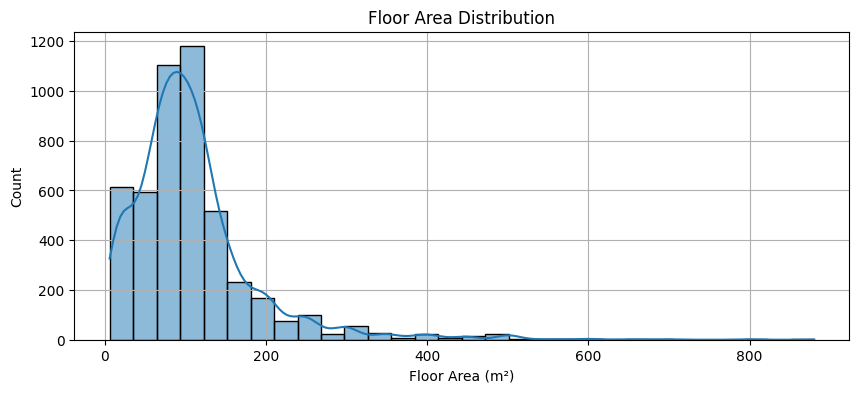

In [548]:
plt.figure(figsize=(10, 4))
sns.histplot(train_data['floor_area'], bins=30, kde=True)
plt.title("Floor Area Distribution")
plt.xlabel("Floor Area (m²)")
plt.ylabel("Count")
plt.grid(True)
plt.show()

In [549]:
def categorize_floor_area(area):
    if area < 30:
        return 'compact'
    elif 30 <= area < 60:
        return 'small'
    elif 60 <= area < 100:
        return 'medium'
    elif 100 <= area < 150:
        return 'large'
    else:
        return 'very_large'

train_data['floor_area_category'] = train_data['floor_area'].apply(categorize_floor_area)


In [550]:
train_data.drop(['success_books','land_area',"floors_count" ,"units_count","leaving_time","entrance_time_max","entrance_time_min" ,"stays_min","title","status" ,"features","province.id","province.url","city.id", "sleep_arrange","floors_count","Unnamed: 0", "id", "description", "sleep_description", "stays_max", "additional_feature", "additional_safety", "additional_rule", "city.url"], axis=1, inplace=True)

In [551]:
train_data.head(2)

,allocation,types,regions,floor_area,bedrooms,guest_number,max_guest_number,rules,min_price,is_clean,...,city.name,ratings.count,ratings.total,ratings.cleanliness,ratings.location,ratings.checkin,ratings.value,has_barbecue,guest_category,floor_area_category
0,entire_place,"['suite', 'villa']",['rural'],60,1,2,3,['pet'],1500000,False,...,رامسر,16,4.2,3.6,4.8,4.4,3.9,1,couple,medium
1,entire_place,['villa'],"['mountain', 'rural']",80,2,5,10,"['pet', 'smoke']",1600000,False,...,رامسر,18,4.5,4.1,4.4,4.9,3.9,1,medium_group,medium


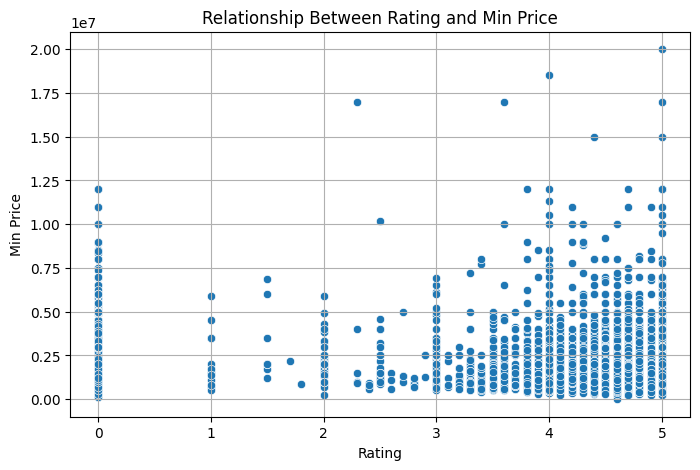

In [552]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data=train_data, x='ratings.value', y='min_price')
plt.title("Relationship Between Rating and Min Price")
plt.xlabel("Rating")
plt.ylabel("Min Price")
plt.grid(True)
plt.show()


In [553]:
train_data['is_zero'] = (train_data['ratings.value'] == 0).astype(int)


In [554]:
train_data['average_area_per_person'] = train_data['floor_area'] / train_data['max_guest_number']

train_data['average_realarea_per_person'] = train_data['floor_area'] / train_data['guest_number']

train_data['average_area_per_bedroom'] = train_data['floor_area'] / (train_data['bedrooms']+1)

train_data = train_data[train_data['max_guest_number'] != 100]

train_data = train_data[train_data["min_price"] > 0]


In [555]:
train_data.columns

Index(['allocation', 'types', 'regions', 'floor_area', 'bedrooms',
       'guest_number', 'max_guest_number', 'rules', 'min_price', 'is_clean',
       'is_new', 'is_instant', 'is_plus', 'geo.lat', 'geo.lng',
       'province.name', 'city.name', 'ratings.count', 'ratings.total',
       'ratings.cleanliness', 'ratings.location', 'ratings.checkin',
       'ratings.value', 'has_barbecue', 'guest_category',
       'floor_area_category', 'is_zero', 'average_area_per_person',
       'average_realarea_per_person', 'average_area_per_bedroom'],
      dtype='object')

In [556]:
train_data_cleaned = train_data

In [557]:
train_data_cleaned["regions"] = train_data_cleaned['regions'].apply(ast.literal_eval)
region_dummies = train_data_cleaned['regions'].explode().str.get_dummies().groupby(level=0).max()
train_data_cleaned = pd.concat([train_data_cleaned.drop(columns='regions'), region_dummies], axis=1)

In [558]:
train_data_cleaned["rules"] = train_data_cleaned['rules'].apply(ast.literal_eval)
rules_dummies = train_data_cleaned['rules'].explode().str.get_dummies().groupby(level=0).max()
train_data_cleaned = pd.concat([train_data_cleaned.drop(columns='rules'), rules_dummies], axis=1)

In [559]:
train_data_cleaned["types"] = train_data_cleaned['types'].apply(ast.literal_eval)
types_dummies = train_data_cleaned['types'].explode().str.get_dummies().groupby(level=0).max()
train_data_cleaned = pd.concat([train_data_cleaned.drop(columns='types'), types_dummies], axis=1)

In [560]:

train_data_cleaned.head()

,allocation,floor_area,bedrooms,guest_number,max_guest_number,min_price,is_clean,is_new,is_instant,is_plus,...,caravansera,cottage,ecolog,hostel,motel,ruralhome,suite,swiss_cottage,villa,wooden_cottage
0,entire_place,60,1,2,3,1500000,False,False,True,False,...,0,0,0,0,0,0,1,0,1,0
1,entire_place,80,2,5,10,1600000,False,False,False,False,...,0,0,0,0,0,0,0,0,1,0
2,entire_place,60,1,2,6,730000,False,False,True,False,...,0,0,0,0,0,0,1,0,0,0
3,entire_place,110,1,6,8,3000000,False,True,False,False,...,0,0,0,0,0,0,0,0,1,0
4,private_room,14,0,2,2,2300000,False,False,False,False,...,0,0,1,0,0,0,0,0,0,0


<Figure size 800x500 with 0 Axes>

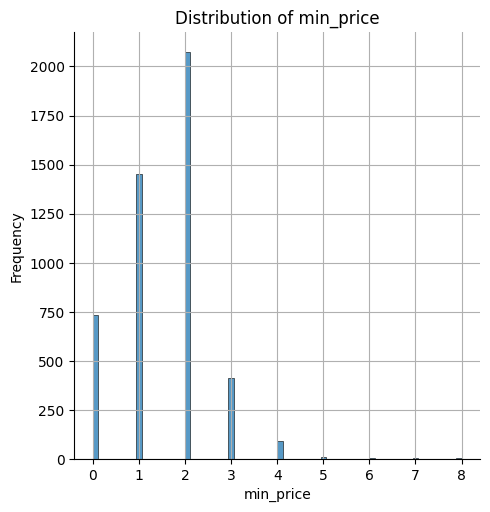

In [641]:
plt.figure(figsize=(8, 5))
sns.displot(train_data_cleaned['bedrooms'], kind='hist')
plt.title('Distribution of min_price')
plt.xlabel('min_price')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [562]:
train_data_cleaned.columns

Index(['allocation', 'floor_area', 'bedrooms', 'guest_number',
       'max_guest_number', 'min_price', 'is_clean', 'is_new', 'is_instant',
       'is_plus', 'geo.lat', 'geo.lng', 'province.name', 'city.name',
       'ratings.count', 'ratings.total', 'ratings.cleanliness',
       'ratings.location', 'ratings.checkin', 'ratings.value', 'has_barbecue',
       'guest_category', 'floor_area_category', 'is_zero',
       'average_area_per_person', 'average_realarea_per_person',
       'average_area_per_bedroom', 'beach', 'desert', 'forest', 'mountain',
       'rural', 'suburb', 'urban', 'party', 'pet', 'smoke', 'unmarried',
       'apartment', 'apartmenthotel', 'boutiquehotel', 'caravansera',
       'cottage', 'ecolog', 'hostel', 'motel', 'ruralhome', 'suite',
       'swiss_cottage', 'villa', 'wooden_cottage'],
      dtype='object')

In [563]:
ordinal_columns = ["city.name", "province.name", "allocation", "is_clean", "is_new", "is_instant", "is_plus", "floor_area_category", "guest_category"]
for column in ordinal_columns:
  train_data_cleaned[column] = train_data_cleaned[column].astype('category')
  ord_enc = OrdinalEncoder()
  train_data_cleaned[column] = ord_enc.fit_transform(train_data_cleaned[[column]])

In [564]:
train_data_cleaned['bedroom_density'] = train_data_cleaned['bedrooms'] / train_data_cleaned['floor_area']
train_data_cleaned['guest_capacity_ratio'] = train_data_cleaned['guest_number'] / train_data_cleaned['max_guest_number']
train_data_cleaned['guest_capacity_diff'] = train_data_cleaned['max_guest_number'] - train_data_cleaned['guest_number']
train_data_cleaned['composite_rating'] = train_data_cleaned[['ratings.cleanliness', 'ratings.location', 'ratings.checkin', 'ratings.value']].mean(axis=1)
train_data_cleaned['average_rating'] = train_data_cleaned.apply(lambda row: row['ratings.total'] / row['ratings.count'] if row['ratings.count'] > 0 else 0, axis=1)

In [565]:
rating_cols = ['ratings.cleanliness', 'ratings.location', 'ratings.checkin', 'ratings.value']
train_data_cleaned['average_ratings'] = train_data_cleaned[rating_cols].mean(axis=1)
#train_data_cleaned.drop(columns=rating_cols, inplace=True)

In [566]:
is_clean_cols = ['is_clean', 'is_new', 'is_instant', 'is_plus']
train_data_cleaned['is_clean_count'] = train_data_cleaned[is_clean_cols].sum(axis=1)

In [567]:
landscape_cols = ['beach', 'desert', 'forest', 'mountain', 'rural', 'suburb', 'urban']
train_data_cleaned['landscape_diversity'] = train_data_cleaned[landscape_cols].sum(axis=1)
#train_data_cleaned.drop(columns=landscape_cols, inplace=True)

In [568]:
property_type_cols = ['apartment', 'apartmenthotel', 'boutiquehotel', 'caravansera', 'cottage', 'ecolog', 'hostel', 'motel', 'ruralhome', 'suite', 'swiss_cottage', 'villa', 'wooden_cottage']
train_data_cleaned['property_type_count'] = train_data_cleaned[property_type_cols].sum(axis=1)
#train_data_cleaned.drop(columns=property_type_cols, inplace=True)

In [569]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=42)
train_data_cleaned['neighborhood'] = kmeans.fit_predict(train_data_cleaned[['geo.lat', 'geo.lng']])

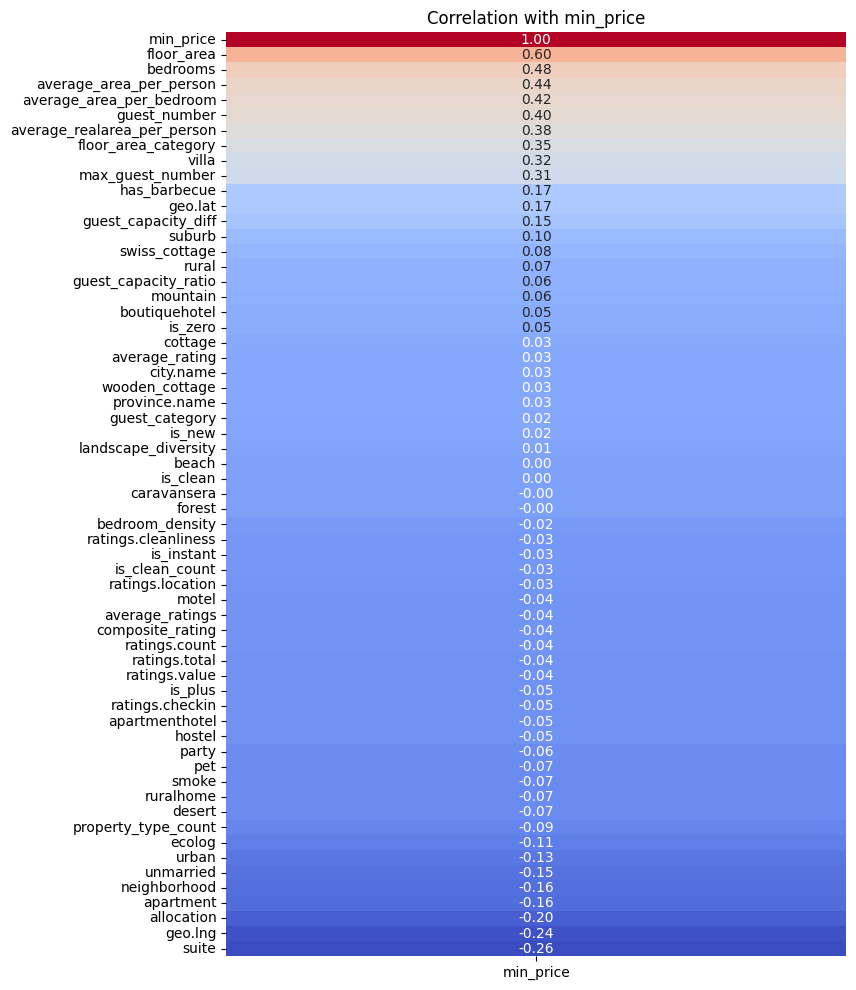

In [570]:
# Compute correlation matrix
corr = train_data_cleaned.corr()

# Select only the min_price correlations (as a DataFrame)
min_price_corr = corr[['min_price']].sort_values(by='min_price', ascending=False)

# Plot heatmap
plt.figure(figsize=(8, 12))  # Tall and narrow
sns.heatmap(min_price_corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=False)
plt.title("Correlation with min_price")
plt.show()


<h2 align=right style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
مدل‌سازی
</font>
</h2>

<p dir=rtl style="direction: rtl; text-align: justify; line-height:200%; font-family:vazir; font-size:medium">
<font face="vazir" size=3>
پس از پاکسازی داده‌ها و احتمالا حذف بعضی ستون‌ها یا افزودن ویژگی‌های جدید، حال وقت آن است که مطابق سلیقه‌ی خود، مدل مناسب را با استفاده از داده‌های پیش‌پردازش شده آموزش دهید.
</font>
</p>

In [571]:
train_data_cleaned.head(2)

,allocation,floor_area,bedrooms,guest_number,max_guest_number,min_price,is_clean,is_new,is_instant,is_plus,...,bedroom_density,guest_capacity_ratio,guest_capacity_diff,composite_rating,average_rating,average_ratings,is_clean_count,landscape_diversity,property_type_count,neighborhood
0,0.0,60,1,2,3,1500000,0.0,0.0,1.0,0.0,...,0.016667,0.666667,1,4.175,0.2625,4.175,1.0,1,2,1
1,0.0,80,2,5,10,1600000,0.0,0.0,0.0,0.0,...,0.025000,0.500000,5,4.325,0.2500,4.325,0.0,2,1,1


In [572]:
train_data_cleaned.columns

Index(['allocation', 'floor_area', 'bedrooms', 'guest_number',
       'max_guest_number', 'min_price', 'is_clean', 'is_new', 'is_instant',
       'is_plus', 'geo.lat', 'geo.lng', 'province.name', 'city.name',
       'ratings.count', 'ratings.total', 'ratings.cleanliness',
       'ratings.location', 'ratings.checkin', 'ratings.value', 'has_barbecue',
       'guest_category', 'floor_area_category', 'is_zero',
       'average_area_per_person', 'average_realarea_per_person',
       'average_area_per_bedroom', 'beach', 'desert', 'forest', 'mountain',
       'rural', 'suburb', 'urban', 'party', 'pet', 'smoke', 'unmarried',
       'apartment', 'apartmenthotel', 'boutiquehotel', 'caravansera',
       'cottage', 'ecolog', 'hostel', 'motel', 'ruralhome', 'suite',
       'swiss_cottage', 'villa', 'wooden_cottage', 'bedroom_density',
       'guest_capacity_ratio', 'guest_capacity_diff', 'composite_rating',
       'average_rating', 'average_ratings', 'is_clean_count',
       'landscape_diversity', 

In [619]:
from sklearn.preprocessing import PowerTransformer
y = train_data_cleaned['min_price']
X = train_data_cleaned.drop(columns =['min_price'])

In [620]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [621]:
X.shape

(4774, 60)

In [625]:
lgb_model = lgb.LGBMRegressor(random_state=42)
xgb_model = xgb.XGBRegressor(random_state=42)
catboost_model = CatBoostRegressor(random_state=42, verbose=0)

In [626]:
lgb_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)
catboost_model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001449 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2023
[LightGBM] [Info] Number of data points in the train set: 3819, number of used features: 58
[LightGBM] [Info] Start training from score 2143234.208693


In [630]:
y_pred = catboost_model.predict(X_test)

r2score = r2_score(y_test, y_pred)

print(f'R2 Score: {r2score}')

R2 Score: 0.5875123796441086


In [594]:
# Set up cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# R² scorer
r2_scorer = make_scorer(r2_score)

# Cross-validation scores
scores = cross_val_score(catboost_model, X, y, cv=kf, scoring=r2_scorer)

# Report results
print(f'R² scores for each fold: {scores}')
print(f'Mean R² score: {scores.mean():.3f}')
print(f'Standard deviation: {scores.std():.3f}')

R² scores for each fold: [0.59461485 0.55088528 0.53653795 0.57226828 0.58033097]
Mean R² score: 0.567
Standard deviation: 0.021


<h2 align=right style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
 پیش‌بینی بر روی داده‌ی آزمون و خروجی
</font>
</h2>

<p dir=rtl style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=3>
    پیش‌بینی مدل خود بر روی داده‌های آزمون را در یک دیتافریم (<code>dataframe</code>) به فرمت زیر ذخیره کنید.
</font>
</p>


<p dir=rtl style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=3>
    توجه داشته باشید که نام دیتافریم باید <code>submission</code> باشد؛ در غیر این‌صورت، سامانه‌ی داوری قادر به ارزیابی خروجی شما نخواهد بود.
    این دیتافریم تنها شامل ۱ ستون با اسم <code>min_price</code> است.
    <br>
    به ازای هر سطر موجود در دیتافریم <code>test</code>، باید یک مقدار پیش‌بینی‌شده داشته باشید.
    به‌عنوان مثال جدول زیر، ۵ سطر ابتدایی دیتافریم <code>submission</code> را نشان می‌دهد. البته در جواب شما، اعداد ستون <code>min_price</code> ممکن است متفاوت باشد.
</font>
</p>

<center>
<div style="direction: ltr;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=3>
    
||<code>min_price</code>|
|:----:|:-----:|
|0|700000|
|1|650000|
|2|5000000|
|3|800000|
|4|750000|

</font>
</div>
</center>

In [446]:
pt = PowerTransformer(method='box-cox')
y = pt.fit_transform(train_data_cleaned[['min_price']])
X = train_data_cleaned.drop(columns =['min_price'])
#y = train_data_cleaned['min_price']
#X = train_data_cleaned.drop(columns =['min_price'])

In [447]:
catboost_model = catboost_model = CatBoostRegressor(verbose=0,random_state=42)
catboost_model.fit(X, y)

In [448]:
test_data['is_zero'] = (test_data['ratings.value'] == 0).astype(int)

test_data['floor_area_category'] = test_data['floor_area'].apply(categorize_floor_area)

test_data['guest_category'] = test_data['guest_number'].apply(categorize_guests)

In [449]:
test_data['average_area_per_person'] = test_data['floor_area'] / test_data['max_guest_number']

test_data['average_realarea_per_person'] = test_data['floor_area'] / test_data['guest_number']

test_data['average_area_per_bedroom'] = test_data['floor_area'] / test_data['bedrooms']

In [450]:
test_data["regions"] = test_data['regions'].apply(ast.literal_eval)
region_dummies = test_data['regions'].explode().str.get_dummies().groupby(level=0).max()
test_data = pd.concat([test_data.drop(columns='regions'), region_dummies], axis=1)

In [451]:
test_data["rules"] = test_data['rules'].apply(ast.literal_eval)
rules_dummies = test_data['rules'].explode().str.get_dummies().groupby(level=0).max()
test_data = pd.concat([test_data.drop(columns='rules'), rules_dummies], axis=1)

In [452]:
test_data["types"] = test_data['types'].apply(ast.literal_eval)
types_dummies = test_data['types'].explode().str.get_dummies().groupby(level=0).max()
test_data = pd.concat([test_data.drop(columns='types'), types_dummies], axis=1)

In [453]:
ordinal_columns = ["city.name", "province.name", "allocation", "is_clean", "is_new", "is_instant", "is_plus", "floor_area_category", "guest_category"]
for column in ordinal_columns:
  test_data[column] = test_data[column].astype('category')
  ord_enc = OrdinalEncoder()
  test_data[column] = ord_enc.fit_transform(test_data[[column]])

In [454]:
test_data['bedroom_density'] = test_data['bedrooms'] / test_data['floor_area']
test_data['guest_capacity_ratio'] = test_data['guest_number'] / test_data['max_guest_number']
test_data['guest_capacity_diff'] = test_data['max_guest_number'] - test_data['guest_number']
test_data['composite_rating'] = test_data[['ratings.cleanliness', 'ratings.location', 'ratings.checkin', 'ratings.value']].mean(axis=1)
test_data['average_rating'] = test_data.apply(lambda row: row['ratings.total'] / row['ratings.count'] if row['ratings.count'] > 0 else 0, axis=1)

In [455]:
rating_cols = ['ratings.cleanliness', 'ratings.location', 'ratings.checkin', 'ratings.value']
test_data['average_ratings'] = test_data[rating_cols].mean(axis=1)
#train_data_cleaned.drop(columns=rating_cols, inplace=True)

In [456]:
is_clean_cols = ['is_clean', 'is_new', 'is_instant', 'is_plus']
test_data['is_clean_count'] = test_data[is_clean_cols].sum(axis=1)

In [457]:
landscape_cols = ['beach', 'desert', 'forest', 'mountain', 'rural', 'suburb', 'urban']
test_data['landscape_diversity'] = test_data[landscape_cols].sum(axis=1)
#train_data_cleaned.drop(columns=landscape_cols, inplace=True)

In [458]:
property_type_cols = ['apartment', 'apartmenthotel', 'boutiquehotel', 'caravansera', 'cottage', 'ecolog', 'hostel', 'motel', 'ruralhome', 'suite', 'swiss_cottage', 'villa', 'wooden_cottage']
test_data['property_type_count'] = test_data[property_type_cols].sum(axis=1)
#train_data_cleaned.drop(columns=property_type_cols, inplace=True)

In [459]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=42)
test_data['neighborhood'] = kmeans.fit_predict(test_data[['geo.lat', 'geo.lng']])

In [460]:
test_data['has_barbecue'] = test_data['features'].str.contains("barbecue", case=False).astype(int)

In [461]:
test_data.drop(['success_books','land_area',"floors_count" ,"units_count","leaving_time","entrance_time_max","entrance_time_min" ,"stays_min","title","status","features","province.id","province.url","city.id", "sleep_arrange","floors_count","Unnamed: 0", "id", "description", "sleep_description", "stays_max", "additional_feature", "additional_safety", "additional_rule", "city.url"], axis=1, inplace=True)

In [462]:
test_data.shape

(1194, 60)

In [463]:
predicted_min_prices = catboost_model.predict(test_data)
predicted_min_prices = pt.inverse_transform(predicted_min_prices.reshape(-1, 1))
predicted_min_prices

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(


array([[1458436.50514761],
       [1353923.8689006 ],
       [1004731.33793267],
       ...,
       [1357497.56440229],
       [4251725.31833579],
       [1002182.46180202]])

In [474]:
predicted_min_prices = predicted_min_prices.ravel()

predicted_min_prices

array([1458436.50514761, 1353923.8689006 , 1004731.33793267, ...,
       1357497.56440229, 4251725.31833579, 1002182.46180202])

In [475]:
# To-Do
submission = pd.DataFrame({
    'min_price': predicted_min_prices
})

submission.head()

,min_price
0,1.458437e+06
1,1.353924e+06
2,1.004731e+06
3,1.155288e+06
4,9.583799e+05


<h2 align=right style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
<b>سلول جواب‌ساز</b>
</font>
</h2>

<p dir=rtl style="direction: rtl; text-align: justify; line-height:200%; font-family:vazir; font-size:medium">
<font face="vazir" size=3>
    برای ساخته‌شدن فایل <code>result.zip</code> سلول زیر را اجرا کنید. توجه داشته باشید که پیش از اجرای سلول زیر تغییرات اعمال شده در نت‌بوک را ذخیره کرده باشید (<code>ctrl+s</code>) تا در صورت نیاز به پشتیبانی امکان بررسی کد شما وجود داشته باشد.
</font>
</p>

In [476]:
import zipfile

def compress(file_names):
    print("File Paths:")
    print(file_names)
    compression = zipfile.ZIP_DEFLATED
    with zipfile.ZipFile("result.zip", mode="w") as zf:
        for file_name in file_names:
            zf.write(file_name, file_name, compress_type=compression)

submission.to_csv('submission.csv', index=False)
file_names = ['submission.csv', 'Jajiga.ipynb']
compress(file_names)

File Paths:
['submission.csv', 'Jajiga.ipynb']


FileNotFoundError: [Errno 2] No such file or directory: 'Jajiga.ipynb'